# Idea

Choose 3 Bragg peaks that probably generated by the same grain.

Choose 2 from 3, for example, No.0 peak and No.1 peak.

For each hkl of peak No.0 , for each hkl of peak No.1, get U matrix from the two hkls, named U1.

There will be many U1 matrix.

Choose another 2 from 3, for example, No.0 peak and No.2 peak.

For each hkl of peak No.0 , for each kl of peak No.2, get U matrix from the two hkls, named U2.

There will be many U2 matrix.

Find the most similar U1 and U2 matrix, this should be the correct one because two sets of hkls from the same should yield the same U matrix.

If we choose No.0 and No.1 to get many U1 and choose No.0 and No.2 to get many U2 and find the most similar ones between U1 and U2, named U12.

If we choose No.0 and No.1 to get many U1 and choose No.1 and No.2 to get many U3 and find the most similar ones between U1 and U3, named U13.

U12 and U13 are similar or not? The hkls for the No.0, No.1 and No.2 are similar or not?

# Choose Peaks

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import typing

from crystalmapping.ubmatrix import UBMatrix
from crystalmapping.utils import auto_plot_dataset, Calculator

In [2]:
data = xr.open_dataset("./data/CG_0046_full_range_grid_scan_90_degree_40_p_20_w.nc")

In [3]:
data = data.sel({"grain": [23, 6, 29]})

In [4]:
df = data[["x", "y", "Q"]].to_dataframe()
df["Q"] /= 10.
df

,x,y,Q
grain,,,
23,2653,1004,6.326495
6,1538,390,8.421187
29,1677,1335,4.237960


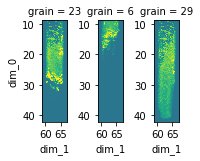

In [5]:
auto_plot_dataset(
    data,
    invert_y=True,
    aspect=33. / 133.,
)
plt.show()

In [6]:
calc = Calculator()

In [7]:
calc.windows = df

In [8]:
calc.load_cell_from_cif("./data/tio2_rutile.cif")

In [9]:
calc.calc_hkls(0.98, 1.02)

In [10]:
calc.windows

,x,y,Q,d
grain,,,,
23,2653,1004,6.326495,0.993154
6,1538,390,8.421187,0.746116
29,1677,1335,4.237960,1.482597


In [11]:
ubm = UBMatrix()

In [12]:
ubm.set_lat_from_cif("./data/tio2_rutile.cif")
ubm.set_geo_from_poni("./data/CeO2_0.25x0.25_beam.poni")
ubm.get_B()

In [13]:
ubm.lat

Lattice(a=4.5918, b=4.5918, c=2.9588, alpha=90, beta=90, gamma=90)

In [42]:
calc.n_hkl

array([[ 2,  0,  0],
       [ 8,  8, 16],
       [ 2,  0,  0]])

In [70]:
def show_hkls():
    for i in range(calc.n_hkl.shape[0]):
        print("Possible hkls for No.{}:".format(i))
        nums = calc.n_hkl[i]
        for hkls, num in zip(calc.hkl[i], nums):
            for hkl in hkls[:num]:
                print(hkl)
    return

In [71]:
show_hkls()

Possible hkls for No.0:
[ 0  0 -3]
[0 0 3]
Possible hkls for No.1:
[-4  0 -3]
[-4  0  3]
[ 0 -4 -3]
[ 0 -4  3]
[ 0  4 -3]
[0 4 3]
[ 4  0 -3]
[4 0 3]
[-6 -1  0]
[-6  1  0]
[-1 -6  0]
[-1  6  0]
[ 1 -6  0]
[1 6 0]
[ 6 -1  0]
[6 1 0]
[-5 -3 -1]
[-5 -3  1]
[-5  3 -1]
[-5  3  1]
[-3 -5 -1]
[-3 -5  1]
[-3  5 -1]
[-3  5  1]
[ 3 -5 -1]
[ 3 -5  1]
[ 3  5 -1]
[3 5 1]
[ 5 -3 -1]
[ 5 -3  1]
[ 5  3 -1]
[5 3 1]
Possible hkls for No.2:
[ 0  0 -2]
[0 0 2]


# Comparison

In [12]:
def get_U(idx1: typing.Sequence[int], idx2: typing.Sequence[int]) -> tuple:
    """Selet two hkls from the idx and calculate U."""
    hkl1 = calc.hkl[idx1[0], idx1[1], idx1[2]]
    hkl2 = calc.hkl[idx2[0], idx2[1], idx2[2]]
    xy1 = np.array([calc.windows["x"].iloc[idx1[0]], calc.windows["y"].iloc[idx1[0]]])
    xy2 = np.array([calc.windows["x"].iloc[idx2[0]], calc.windows["y"].iloc[idx2[0]]])
    ubm.set_h1_from_hkl(hkl1)
    ubm.set_h2_from_hkl(hkl2)
    ubm.set_u1_from_xy(xy1)
    ubm.set_u2_from_xy(xy2)
    ubm.get_U()
    return hkl1, hkl2, ubm.U.copy()


def gen_idx(grain_idx: int) -> typing.Sequence[int]:
    """Generate index of hkl for a grain."""
    n_hkl = calc.n_hkl[grain_idx]
    for d_idx in range(n_hkl.shape[0]):
        for hkl_idx in range(n_hkl[d_idx]):
            yield (grain_idx, d_idx, hkl_idx)
            
            
def get_Us(grain_idx1: int, grain_idx2: int) -> tuple:
    hkl1s, hkl2s, Us = [], [], []
    for idx1 in gen_idx(grain_idx1):
        for idx2 in gen_idx(grain_idx2):
            hkl1, hkl2, U = get_U(idx1, idx2)
            hkl1s.append(hkl1)
            hkl2s.append(hkl2)
            Us.append(U)
    return np.asarray(hkl1s), np.asarray(hkl2s), np.asarray(Us)


def compare_Us(Us1: xr.Dataset, Us2: xr.Dataset) -> xr.Dataset:
    n1 = Us1.shape[0]
    n2 = Us2.shape[0]
    res = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            res[i, j] = np.sum(Us1[i] * Us2[j]) / 3.
    return res


def get_Us_and_compare(
    grain_idxs1: typing.Tuple[int, int], 
    grain_idxs2: typing.Tuple[int, int]
) -> xr.Dataset:
    hkl1s1, hkl2s1, Us1 = get_Us(*grain_idxs1)
    hkl1s2, hkl2s2, Us2 = get_Us(*grain_idxs2)
    Inner = compare_Us(Us1, Us2)
    return xr.Dataset(
        {
            "grain_idxs1": (["dim_5"], list(grain_idxs1)),
            "grain_idxs2": (["dim_5"], list(grain_idxs2)),
            "similarity": (["dim_1", "dim_2"], Inner),
            "U1": (["dim_1", "dim_3", "dim_4"], Us1),
            "U2": (["dim_2", "dim_3", "dim_4"], Us2),
            "hkl11": (["dim_1", "dim_0"], hkl1s1),
            "hkl21": (["dim_1", "dim_0"], hkl2s1),
            "hkl12": (["dim_2", "dim_0"], hkl1s2),
            "hkl22": (["dim_2", "dim_0"], hkl2s2)
        }
    )


def get_most_similar():
    a = result["similarity"].values
    idxs = np.unravel_index(np.argmax(a, axis=None), a.shape)
    return result.isel({"dim_1": idxs[0], "dim_2": idxs[1]})


def report():
    hkl11_str = ", ".join(["{:d}".format(v) for v in sel_result["hkl11"].values])
    hkl21_str = ", ".join(["{:d}".format(v) for v in sel_result["hkl21"].values])
    hkl12_str = ", ".join(["{:d}".format(v) for v in sel_result["hkl12"].values])
    hkl22_str = ", ".join(["{:d}".format(v) for v in sel_result["hkl22"].values])
    hkls = []
    hkls.append([sel_result["grain_idxs1"].values[0], hkl11_str])
    hkls.append([sel_result["grain_idxs1"].values[1], hkl21_str])
    hkls.append([sel_result["grain_idxs2"].values[0], hkl12_str])
    hkls.append([sel_result["grain_idxs2"].values[1], hkl22_str])
    print(
        "This is the report of the most similar U matrix from two group of hkls."
    )
    for k, v in sorted(hkls):
        print("hkl for grain No.{} is ({})".format(k, v))
    print(
        "The first U matrix is"
    )
    print(
        sel_result["U1"].values
    )
    print(
        "The first U matrix is derived from the Bragg peak No.{} and No.{}".format(*sel_result["grain_idxs1"].values)
    )
    print(
        "Their hkls are: ({}) and ({}).".format(hkl11_str, hkl21_str)
    )
    print(
        "The second U matrix is"
    )
    print(
        sel_result["U2"].values
    )
    print(
        "The first U matrix is derived from the Bragg peak No.{} and No.{}".format(*sel_result["grain_idxs2"].values)
    )
    print(
        "Their hkls are: ({}) and ({}).".format(hkl12_str, hkl22_str)
    )
    return



def visualize():
    fig, axes = plt.subplots(1, 2, figsize=(4 * 2, 4))
    # similarity matrix
    result["similarity"].plot.imshow(vmin=-1, vmax=1., ax=axes[0])
    axes[0].set_aspect("equal")
    axes[0].set_title("Similarity Matrix")
    # histogram
    result["similarity"].plot.hist(bins=np.arange(-1, 1.0001, 0.01), ax=axes[1])
    axes[1].set_ylabel("count")
    fig.tight_layout()
    return

## (No.0, No.1) and (No.0, No.2)

In [13]:
result = get_Us_and_compare((0, 1), (0, 2))

In [14]:
sel_result = get_most_similar()

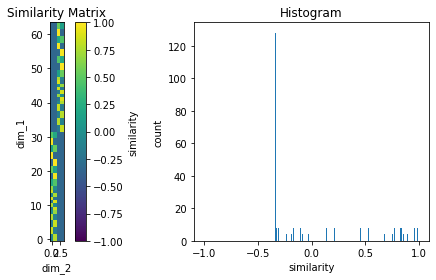

In [15]:
visualize()

In [16]:
report()

This is the report of the most similar U matrix from two group of hkls.
hkl for grain No.0 is (0, 0, -3)
hkl for grain No.0 is (0, 0, -3)
hkl for grain No.1 is (-3, 5, -1)
hkl for grain No.2 is (0, 0, 2)
The first U matrix is
[[ 0.51661702 -0.75413497 -0.40544705]
 [ 0.2894332  -0.29184259  0.91162291]
 [-0.80581343 -0.58830974  0.06750085]]
The first U matrix is derived from the Bragg peak No.0 and No.1
Their hkls are: (0, 0, -3) and (-3, 5, -1).
The second U matrix is
[[ 0.64679829 -0.64596027 -0.40544705]
 [ 0.33827765 -0.23347785  0.91162291]
 [-0.68353508 -0.72678981  0.06750085]]
The first U matrix is derived from the Bragg peak No.0 and No.2
Their hkls are: (0, 0, -3) and (0, 0, 2).


## (No.0, No.1) and (No.1, No.2)

In [33]:
result = get_Us_and_compare((0, 1), (1, 2))

In [34]:
sel_result = get_most_similar()

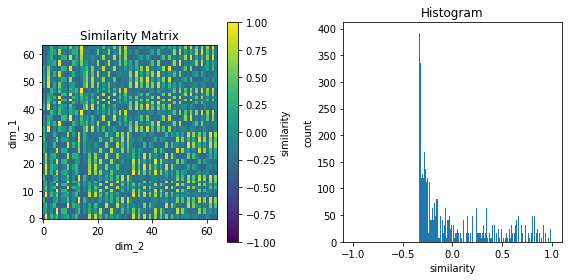

In [35]:
visualize()

In [36]:
report()

This is the report of the most similar U matrix from two group of hkls.
hkl for grain No.0 is (0, 0, -3)
hkl for grain No.1 is (-4, 0, -3)
hkl for grain No.1 is (-6, 1, 0)
hkl for grain No.2 is (0, 0, 2)
The first U matrix is
[[ 0.90908894 -0.09576002 -0.40544705]
 [ 0.40985092  0.03107894  0.91162291]
 [-0.07469617 -0.99491915  0.06750085]]
The first U matrix is derived from the Bragg peak No.0 and No.1
Their hkls are: (0, 0, -3) and (-6, 1, 0).
The second U matrix is
[[ 0.95538681 -0.0994191  -0.27812208]
 [ 0.29155053  0.16674383  0.94191018]
 [-0.04726872 -0.9809752   0.18829055]]
The first U matrix is derived from the Bragg peak No.1 and No.2
Their hkls are: (-4, 0, -3) and (0, 0, 2).


## (No.1, No.2) and (No.0, No.2)

In [38]:
result = get_Us_and_compare((1, 2), (0, 2))

In [39]:
sel_result = get_most_similar()

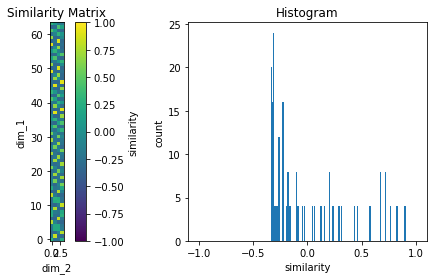

In [40]:
visualize()

In [41]:
report()

This is the report of the most similar U matrix from two group of hkls.
hkl for grain No.0 is (0, 0, -3)
hkl for grain No.1 is (-5, 3, -1)
hkl for grain No.2 is (0, 0, 2)
hkl for grain No.2 is (0, 0, 2)
The first U matrix is
[[ 0.48974732 -0.40978999 -0.76955814]
 [ 0.74864387 -0.25473127  0.61208196]
 [-0.44685558 -0.87589049  0.18203281]]
The first U matrix is derived from the Bragg peak No.1 and No.2
Their hkls are: (-5, 3, -1) and (0, 0, 2).
The second U matrix is
[[ 0.64679829 -0.64596027 -0.40544705]
 [ 0.33827765 -0.23347785  0.91162291]
 [-0.68353508 -0.72678981  0.06750085]]
The first U matrix is derived from the Bragg peak No.0 and No.2
Their hkls are: (0, 0, -3) and (0, 0, 2).


# Summary

The most similar U matrix is different if we used different pairs of Bragg peaks to calculate U matrix.

We need have a way to determine the hkl of one Bragg peak as the initial guess.